<a href="https://colab.research.google.com/github/ITU-Business-Analytics-Team/Business_Analytics_for_Professionals/blob/main/Part%20II%20%3A%20Business%20Applications/Chapter%2015%3A%20Manufacturing%20Analytics/15_3_3_Failure_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Manufacturing Analytics**
## Predictive Maintenance

### Failure Prediction

### Dataset Explanation
*data link: https://data.nasa.gov/dataset/C-MAPSS-Aircraft-Engine-Simulator-Data/xaut-bemq*

The given dataset was generated by the C-MAPSS simulator. The data includes the initial setting data of 100 different turbofans and the data of the sensors on the turbofans. These are time-series data. The main purpose of the models to be established is to make predictive maintenance estimations by the turbofan company. Estimations were made by establishing classification and regression models using the data described below.

* time, in cycles  Engine working cycle
-os1              operational settings 1 for engine performance
-os2              operational settings 2 for engine performance
-os3              operational settings 3 for engine performance
-sensor_01        Measurement data of Sensor 1
-sensor_02        Measurement data of Sensor 2
-sensor_03.       Measurement data of Sensor 3
-    .
-    .
-    .
-sensor_25        Measurement data of Sensor 25
-sensor_26        Measurement data of Sensor 26



### **Failure Prediction**

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import missingno as msno

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

## Libraries and Functions For Regression  ##
# from sklearn.utils import check_array
from sklearn.metrics import mean_absolute_error 
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso, Ridge, ElasticNet
from sklearn.svm import SVR, LinearSVR
import xgboost as xgb

## Libraries and Functions For Classification ##
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, plot_confusion_matrix
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression

### Data Exploration


In [ ]:
url = "https://drive.google.com/file/d/1_GFvONFKen0gV8oTA8zd4kxga8E-JfS8/view?usp=sharing"
path = 'https://drive.google.com/uc?export=download&id='+url.split('/')[-2]

# The csv file to be used in model training has been imported.
df = pd.read_csv(path)
df_base = df.copy()
df.head()

unit_num  cycle_time     os1  ...  sensor_24  sensor_25  sensor_26
0         1           1 -0.0007  ...        NaN        NaN        NaN
1         1           2  0.0019  ...        NaN        NaN        NaN
2         1           3 -0.0043  ...        NaN        NaN        NaN
3         1           4  0.0007  ...        NaN        NaN        NaN
4         1           5 -0.0019  ...        NaN        NaN        NaN

[5 rows x 31 columns]

In [ ]:
# Data types of features and amount of null data has been examined.
df.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20631 entries, 0 to 20630
Data columns (total 31 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   unit_num    20631 non-null  int64  
 1   cycle_time  20631 non-null  int64  
 2   os1         20631 non-null  float64
 3   os2         20631 non-null  float64
 4   os3         20631 non-null  float64
 5   sensor_01   20631 non-null  float64
 6   sensor_02   20631 non-null  float64
 7   sensor_03   20631 non-null  float64
 8   sensor_04   20631 non-null  float64
 9   sensor_05   20631 non-null  float64
 10  sensor_06   20631 non-null  float64
 11  sensor_07   20631 non-null  float64
 12  sensor_08   20631 non-null  float64
 13  sensor_09   20631 non-null  float64
 14  sensor_10   20631 non-null  float64
 15  sensor_11   20631 non-null  float64
 16  sensor_12   20631 non-null  float64
 17  sensor_13   20631 non-null  float64
 18  sensor_14   20631 non-null  float64
 19  sensor_15   20631 non-nul

In [ ]:
# Statistical properties like mean, standard deviation and quartiles has been examined to analyze distribution of data.
df.describe() 

unit_num    cycle_time  ...  sensor_25  sensor_26
count  20631.000000  20631.000000  ...        0.0        0.0
mean      51.506568    108.807862  ...        NaN        NaN
std       29.227633     68.880990  ...        NaN        NaN
min        1.000000      1.000000  ...        NaN        NaN
25%       26.000000     52.000000  ...        NaN        NaN
50%       52.000000    104.000000  ...        NaN        NaN
75%       77.000000    156.000000  ...        NaN        NaN
max      100.000000    362.000000  ...        NaN        NaN

[8 rows x 31 columns]

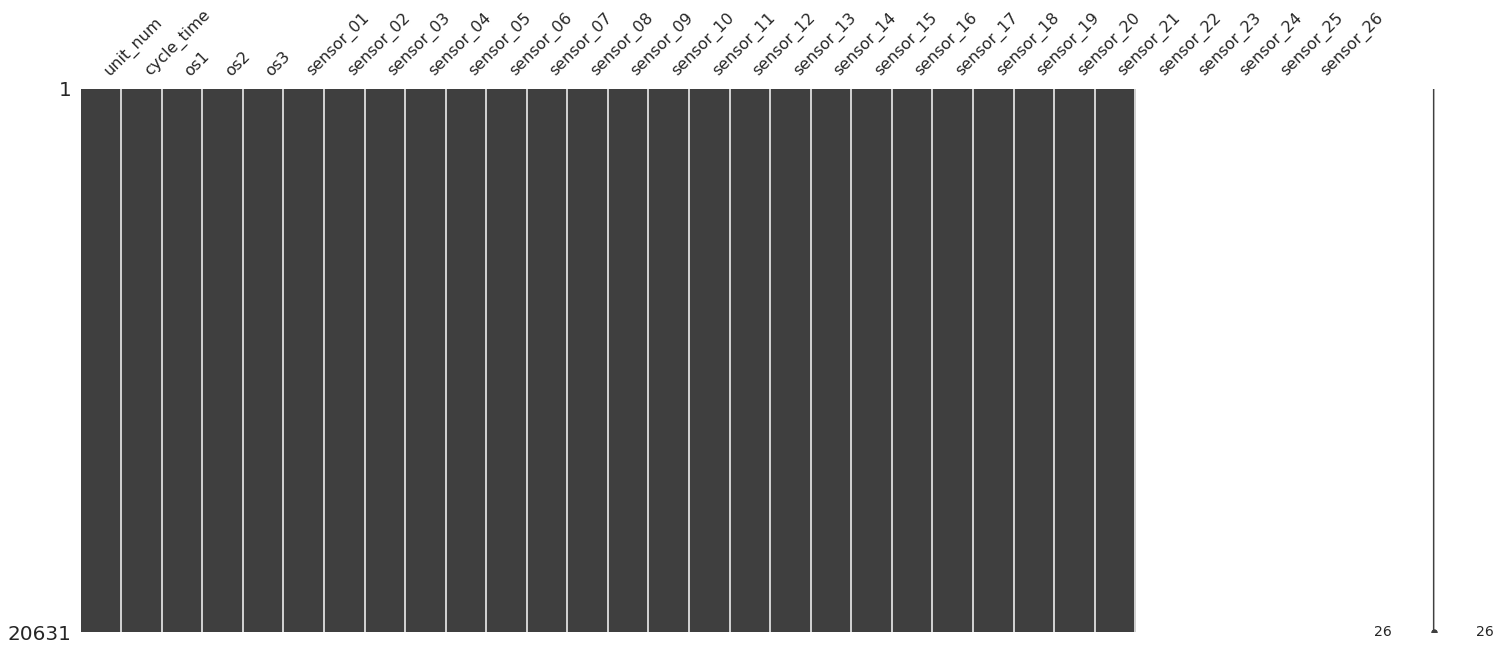

In [ ]:
# Msno library has been used to visualize null data.
msno.matrix(df)
plt.show()

#### Feature Engineering

In [ ]:
# Columns with no data and only one data has been found to be excluded from the model.
# If there is no change in the data, there is no information that the model can learn from.
na_list = df.columns[df.isna().any()].tolist()
const_list = [col for col in df.columns if len(df[col].unique()) <= 1] 
print(na_list)
print(const_list)

['sensor_22', 'sensor_23', 'sensor_24', 'sensor_25', 'sensor_26']
['os3', 'sensor_01', 'sensor_05', 'sensor_10', 'sensor_16', 'sensor_18', 'sensor_19', 'sensor_22', 'sensor_23', 'sensor_24', 'sensor_25', 'sensor_26']


In [ ]:
# Columns with no data and only one data has been drop.
df_base = df.copy()
df.drop(columns=na_list+const_list,axis=1, inplace=True)

In [ ]:
df.describe()

unit_num    cycle_time  ...     sensor_20     sensor_21
count  20631.000000  20631.000000  ...  20631.000000  20631.000000
mean      51.506568    108.807862  ...     38.816271     23.289705
std       29.227633     68.880990  ...      0.180746      0.108251
min        1.000000      1.000000  ...     38.140000     22.894200
25%       26.000000     52.000000  ...     38.700000     23.221800
50%       52.000000    104.000000  ...     38.830000     23.297900
75%       77.000000    156.000000  ...     38.950000     23.366800
max      100.000000    362.000000  ...     39.430000     23.618400

[8 rows x 19 columns]

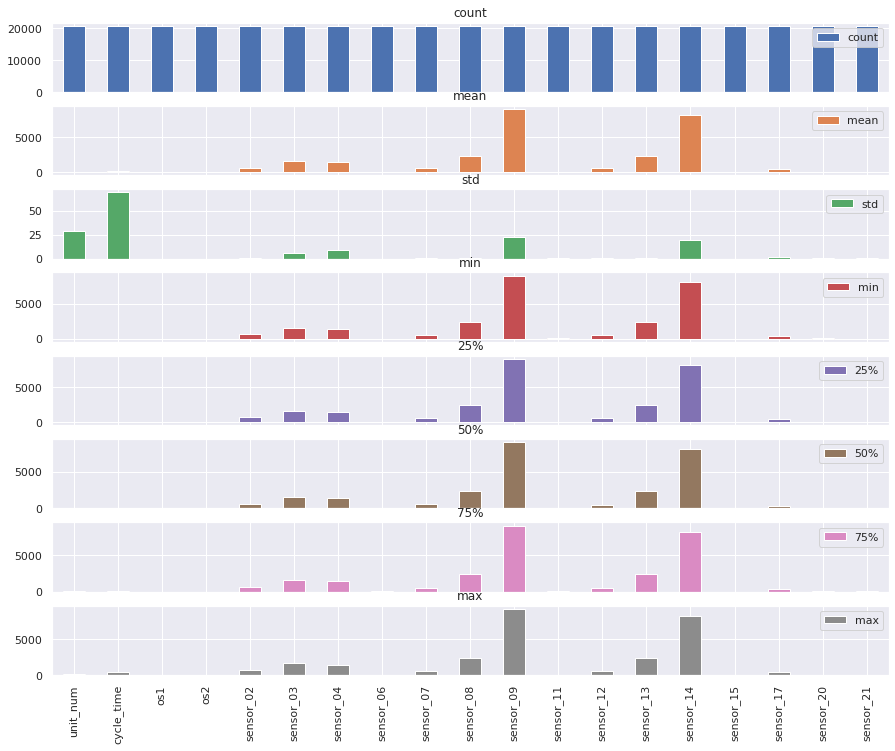

In [ ]:
# By comparing the statistical properties of the features, it has been decided whether it is necessary to bring them to the same level in space.
desc_plot = df.describe().T.plot.bar(subplots=True, figsize=(15,12))

In [ ]:
# In order to establish the regression model, it is necessary to calculate the remaining useful life of the turbofans.
units = df_base["unit_num"].unique().tolist()
dicti = {}
for i in units:
    dicti[i] = df_base[df_base["unit_num"] == i]["cycle_time"].max() 
df_base["RUL"] = df_base["unit_num"].apply(lambda key: dicti[key]) - df_base["cycle_time"]

#### Visualization

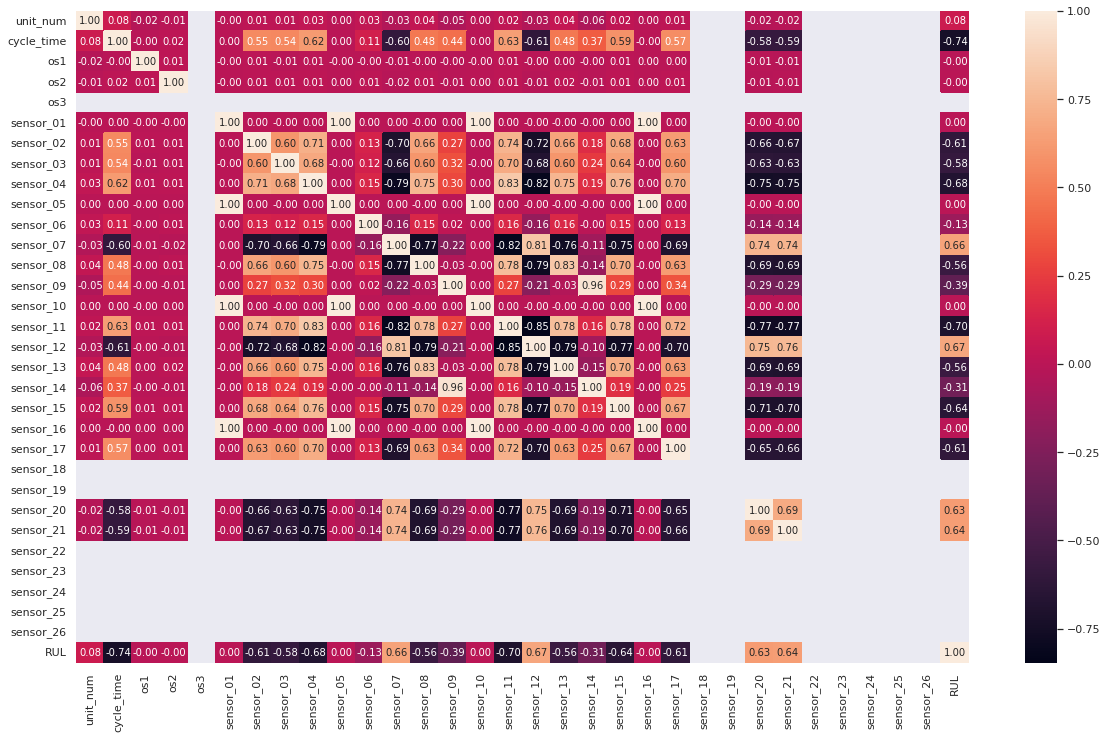

In [ ]:
# A heatmap has been used to visualize the inter-feature correlation. Thus, at least one feature has been discarded in order to eliminate bias in the model with highly correlated features.
plt.figure(figsize=(20,12))
sns.heatmap(df_base.corr(), annot=True, fmt='.2f')
plt.show()

In [ ]:
units = df["unit_num"].unique().tolist()
dicti = {}
for i in units:
    dicti[i] = df[df["unit_num"] == i]["cycle_time"].max()    
df["RUL"] = df["unit_num"].apply(lambda key: dicti[key]) - df["cycle_time"]

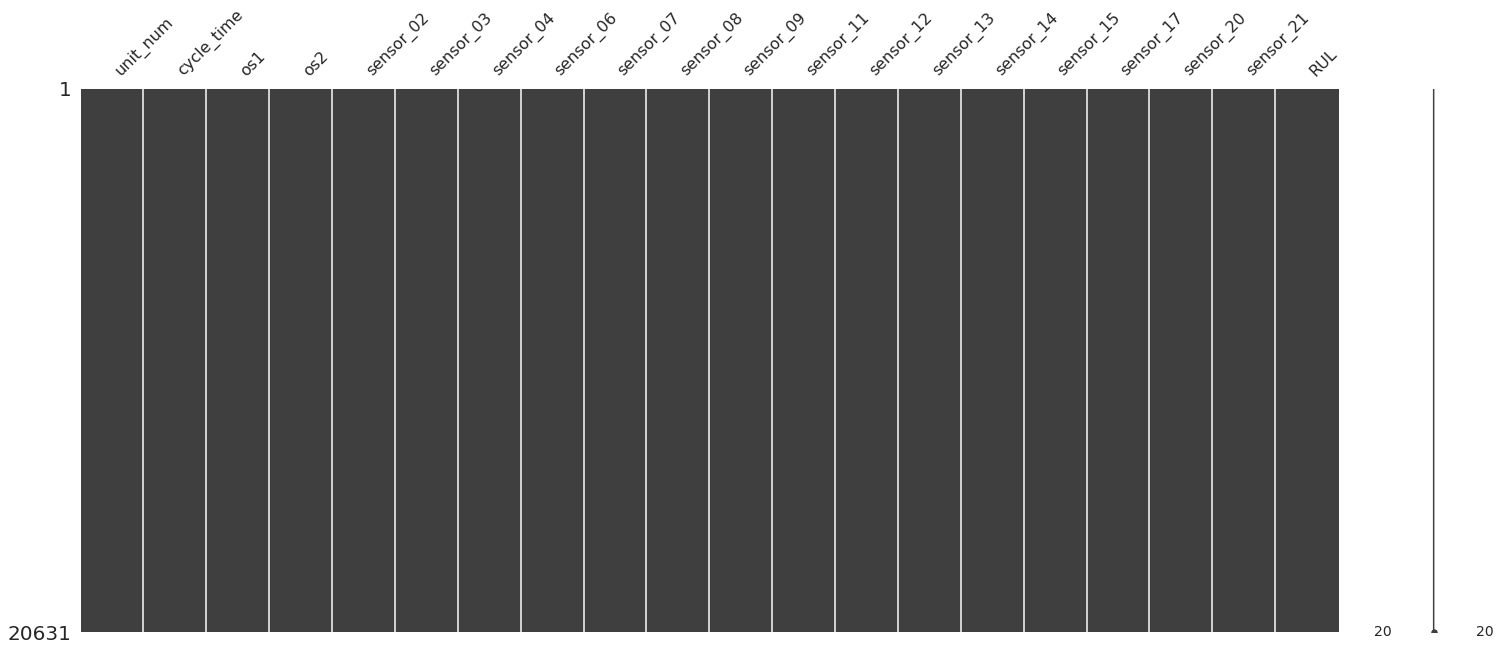

In [ ]:
msno.matrix(df)
plt.show()

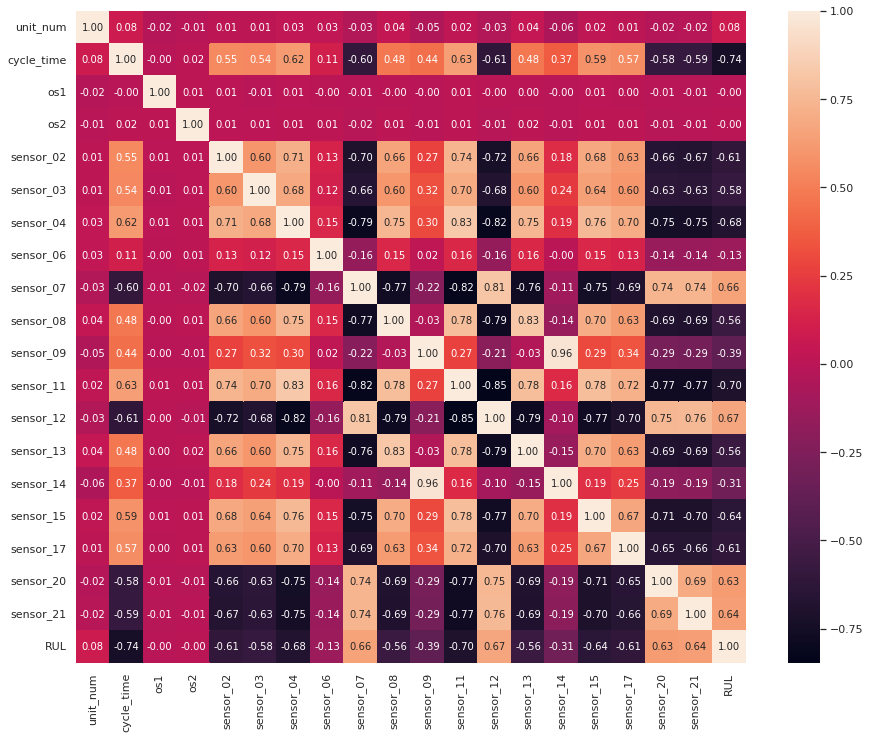

In [ ]:
# A heatmap has been used to visualize the inter-feature correlation. Thus, at least one feature has been discarded in order to eliminate bias in the model with highly correlated features.
plt.figure(figsize=(15,12))
sns.heatmap(df.corr(), annot=True, fmt='.2f')
plt.show()

In [ ]:
# In order to eliminate the multicollinearity problem, one of the features with a linearity ratio greater than 0.8 has been excluded from the data.
corr_mat = df.drop(['unit_num','cycle_time'], axis=1).corr()
high_corr = []
for i in corr_mat.columns:
    for j in range(len(corr_mat)):
        if corr_mat[i].iloc[j]>0.8 or corr_mat[i].iloc[j] < -0.8 :
            if i == corr_mat.index[j] or (corr_mat.index[j], i, corr_mat[i].iloc[j]) in high_corr:
                continue
            else:
                high_corr.append((i, corr_mat.index[j], corr_mat[i].iloc[j]))          
high_corr

[('sensor_04', 'sensor_11', 0.8301356963159666),
 ('sensor_04', 'sensor_12', -0.8155905161052416),
 ('sensor_07', 'sensor_11', -0.8228050249957727),
 ('sensor_07', 'sensor_12', 0.8127126013254434),
 ('sensor_08', 'sensor_13', 0.8260843322358152),
 ('sensor_09', 'sensor_14', 0.9631566003059564),
 ('sensor_11', 'sensor_12', -0.8468835930051064)]

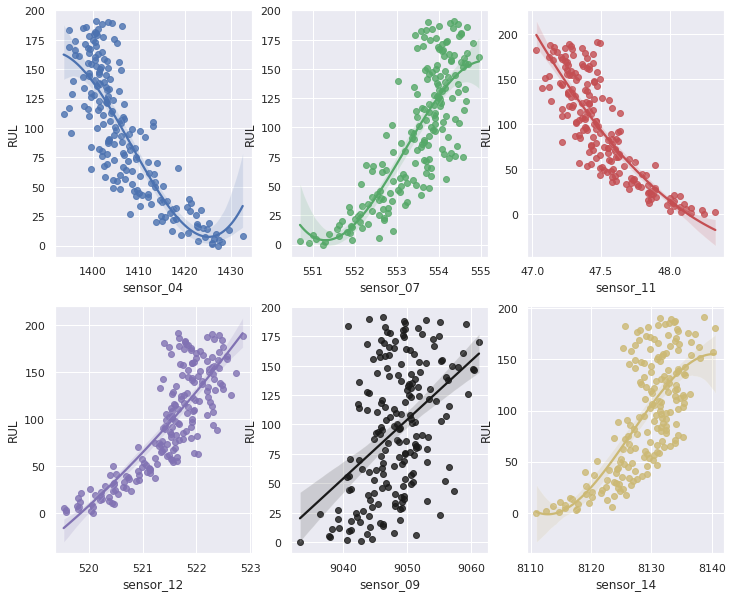

In [ ]:
# In order to understand the correlation between the sensor data and the RUL column, sample features have been selected and the function has been tried to be fitted.
df_unit_1 = df[df["unit_num"] == 1]

fig, axes = plt.subplots(2,3)
fig.set_size_inches(12,10)

sns.regplot(x="sensor_04", y="RUL", data=df_unit_1, ax= axes[0][0], order=3)
sns.regplot(x="sensor_07", y="RUL", data=df_unit_1, ax= axes[0][1], order=3, color ='g')
sns.regplot(x="sensor_11", y="RUL", data=df_unit_1, ax= axes[0][2], order=2, color = 'r')
sns.regplot(x="sensor_12", y="RUL", data=df_unit_1, ax= axes[1][0], order=2, color = 'm')
sns.regplot(x="sensor_09", y="RUL", data=df_unit_1, ax= axes[1][1], color = 'k')
sns.regplot(x="sensor_14", y="RUL", data=df_unit_1, ax= axes[1][2], order=3, color = 'y')

plt.show()


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

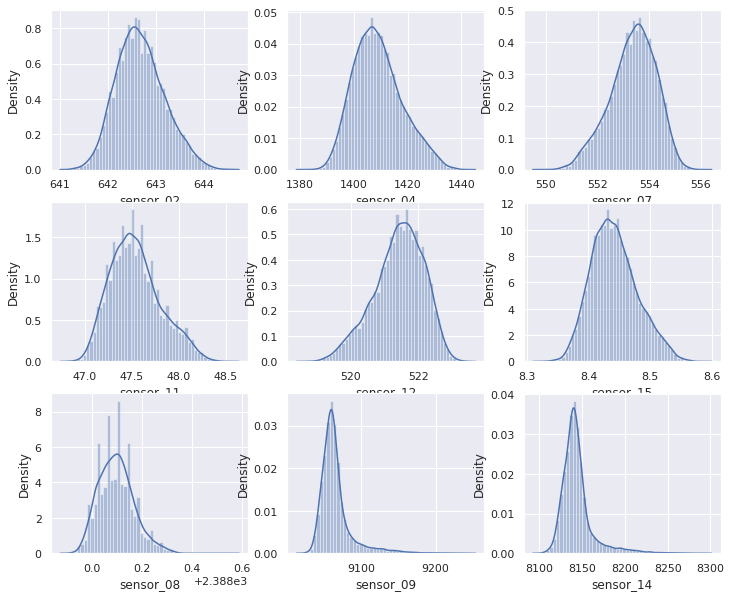

In [ ]:
# Distribution of the collected sensor data has been visualized and compared the similarity to the normal distribution.
fig, axes = plt.subplots(3,3)
fig.set_size_inches(12,10)

sns.distplot(df["sensor_02"], ax= axes[0][0])
sns.distplot(df["sensor_04"], ax= axes[0][1])
sns.distplot(df["sensor_07"], ax= axes[0][2])
sns.distplot(df["sensor_11"], ax= axes[1][0])
sns.distplot(df["sensor_12"], ax= axes[1][1])
sns.distplot(df["sensor_15"], ax= axes[1][2])
sns.distplot(df["sensor_08"], ax= axes[2][0])
sns.distplot(df["sensor_09"], ax= axes[2][1])
sns.distplot(df["sensor_14"], ax= axes[2][2])

plt.show()


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


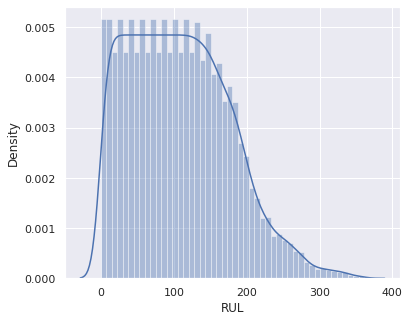

In [ ]:
fig, axes = plt.subplots()
fig.set_size_inches(6,5)

sns.distplot(df["RUL"])

plt.show()

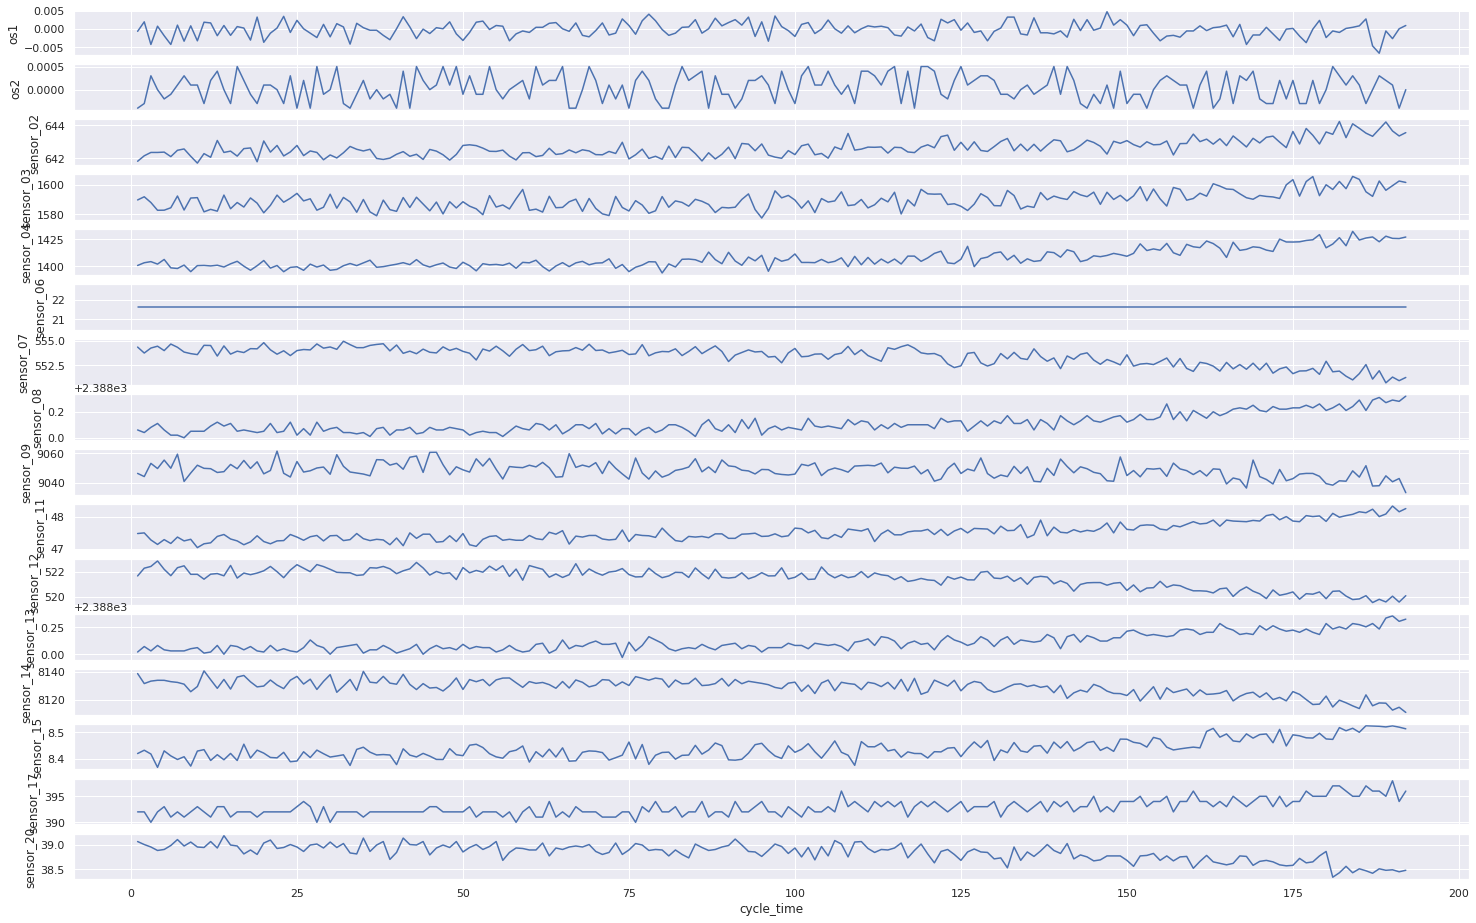

In [ ]:
# All data collected from unit 1 has been visualized according to the cycle time. Thus, in order to determine the threshold, the cycle times in which the deviations in the data begin has been tried to estimated.
fig, axes = plt.subplots(16,1)
fig.set_size_inches(25,16)
sns.set_context("paper", font_scale=1)   

for ax1,j in zip(axes.flatten(),df_unit_1.columns[2:-1]):
    sns.lineplot(x=df_unit_1["cycle_time"], y=df_unit_1[j], linewidth=1.5, ax=ax1)

plt.show()

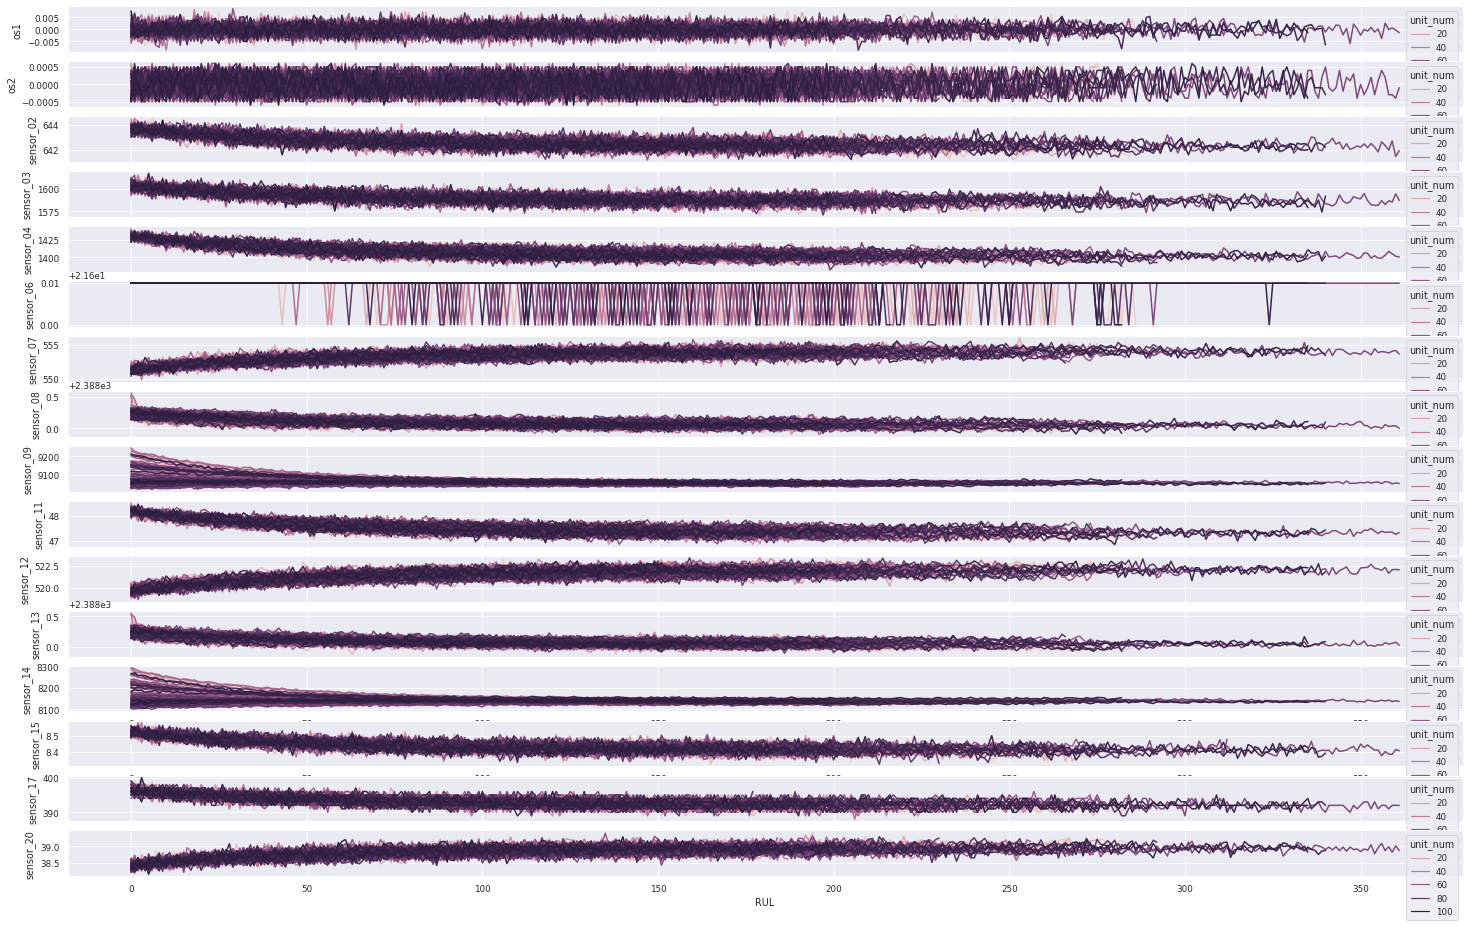

In [ ]:
# Data for all turbofans has been superimposed to ensure that the threshold has been correctly specified.
df_unit_6 = df[df["unit_num"]==6]

fig, axes = plt.subplots(16,1)
fig.set_size_inches(25,16)
sns.set_context("paper", font_scale=1)   

for ax1,j in zip(axes.flatten(),df.columns[2:-1]):
    sns.lineplot(x=df["RUL"].sort_values(ascending=False), y=df[j], hue=df["unit_num"], linewidth=1.5, ax=ax1)

plt.show()

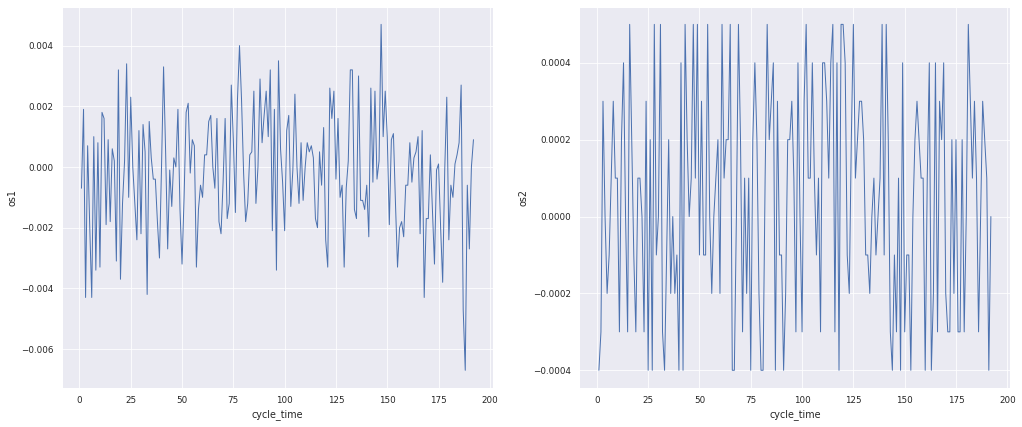

In [ ]:
fig1, axes1 = plt.subplots(1,2)
fig1.set_size_inches(17,7)

sns.set_context("paper", font_scale=1)

sns.lineplot(x=df_unit_1["cycle_time"], y=df_unit_1["os1"], linewidth=1, ax=axes1[0])
sns.lineplot(x=df_unit_1["cycle_time"], y=df_unit_1["os2"], linewidth=1, ax=axes1[1])

plt.show()

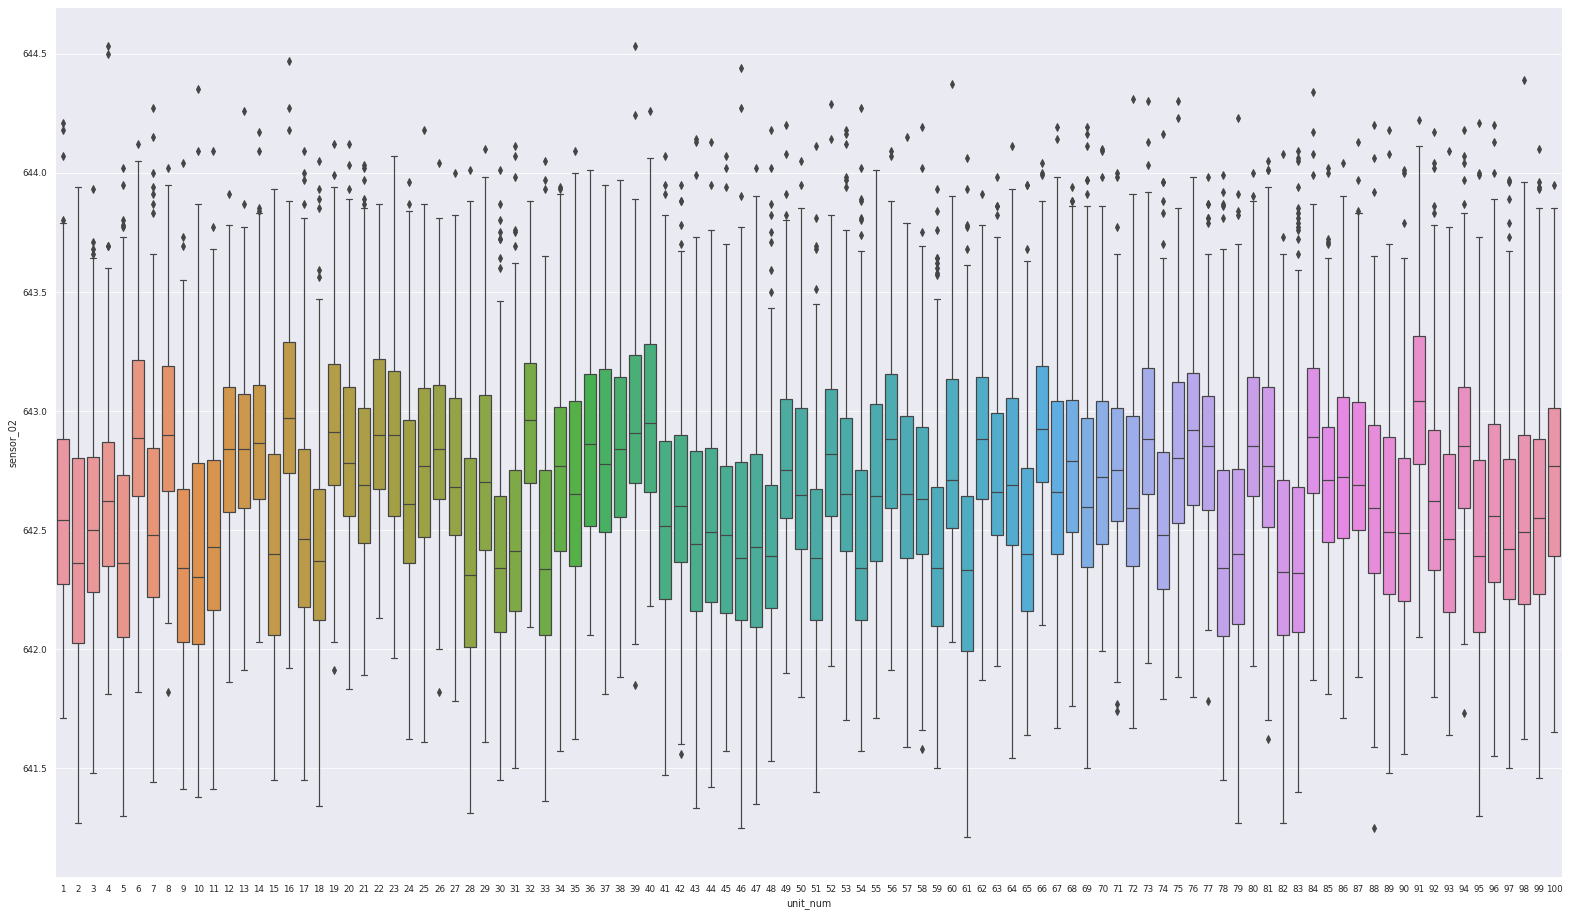

In [ ]:
# Statistical distribution of Sensor 2 data has been examined for all units.
plt.figure(figsize=(27,16))
sns.boxplot(x="unit_num", y="sensor_02",data=df)

plt.show()

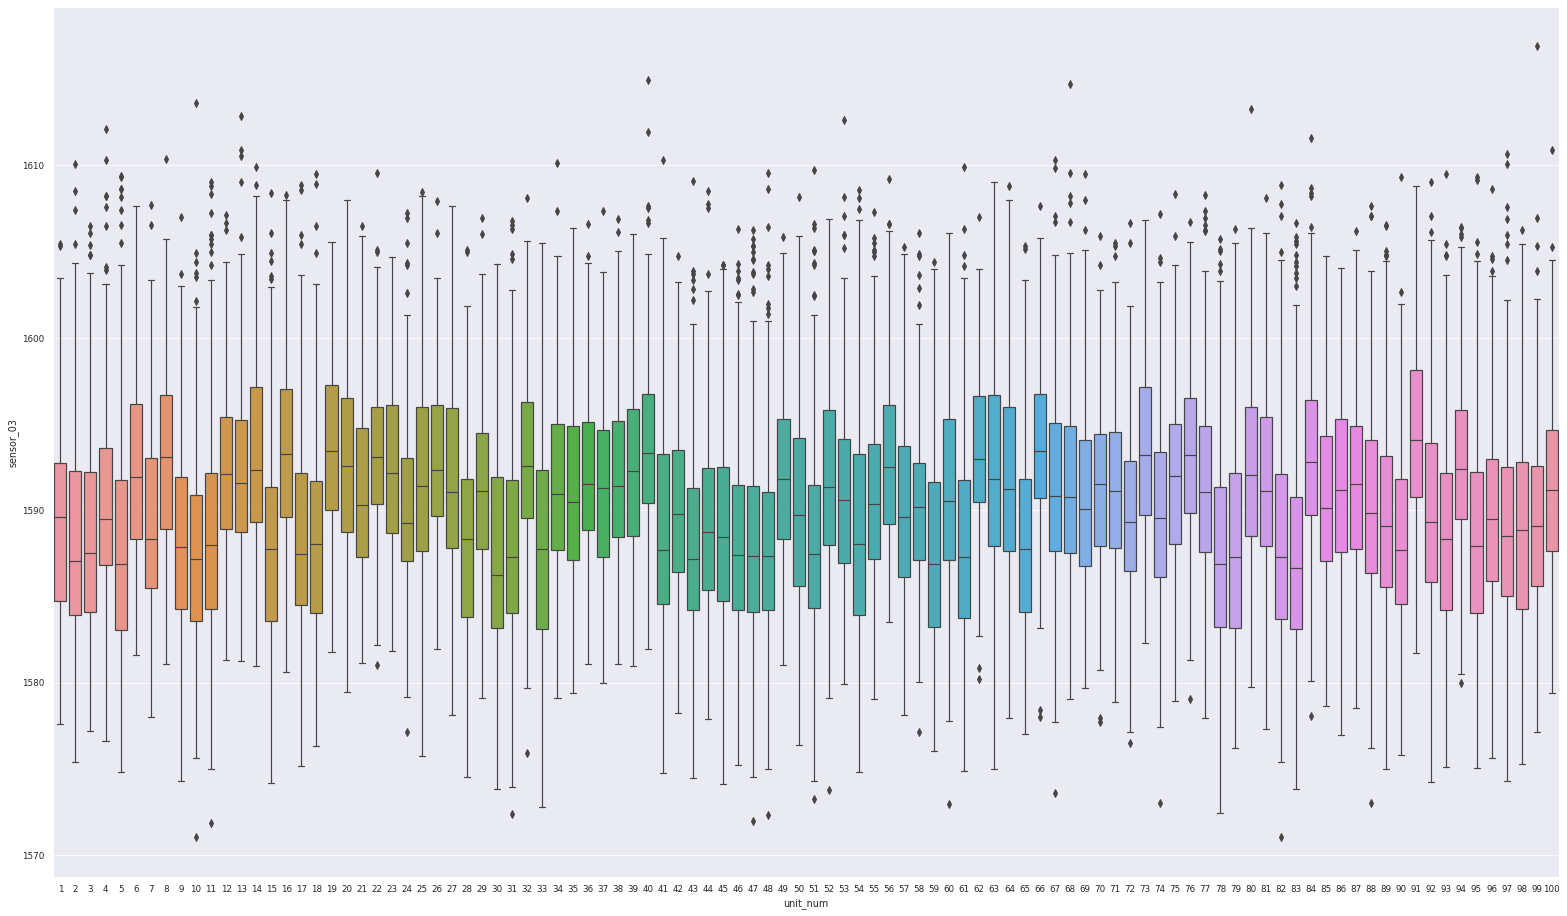

In [ ]:
# Statistical distribution of Sensor 3 data has been examined for all units.
plt.figure(figsize=(27,16))
sns.boxplot(x="unit_num", y="sensor_03",data=df)
plt.show()

In [ ]:
sns.lineplot(x=df["RUL"] ,y=df["sensor_02"],hue=df["unit_num"], linewidth=1.5, ax=ax1)
plt.show()

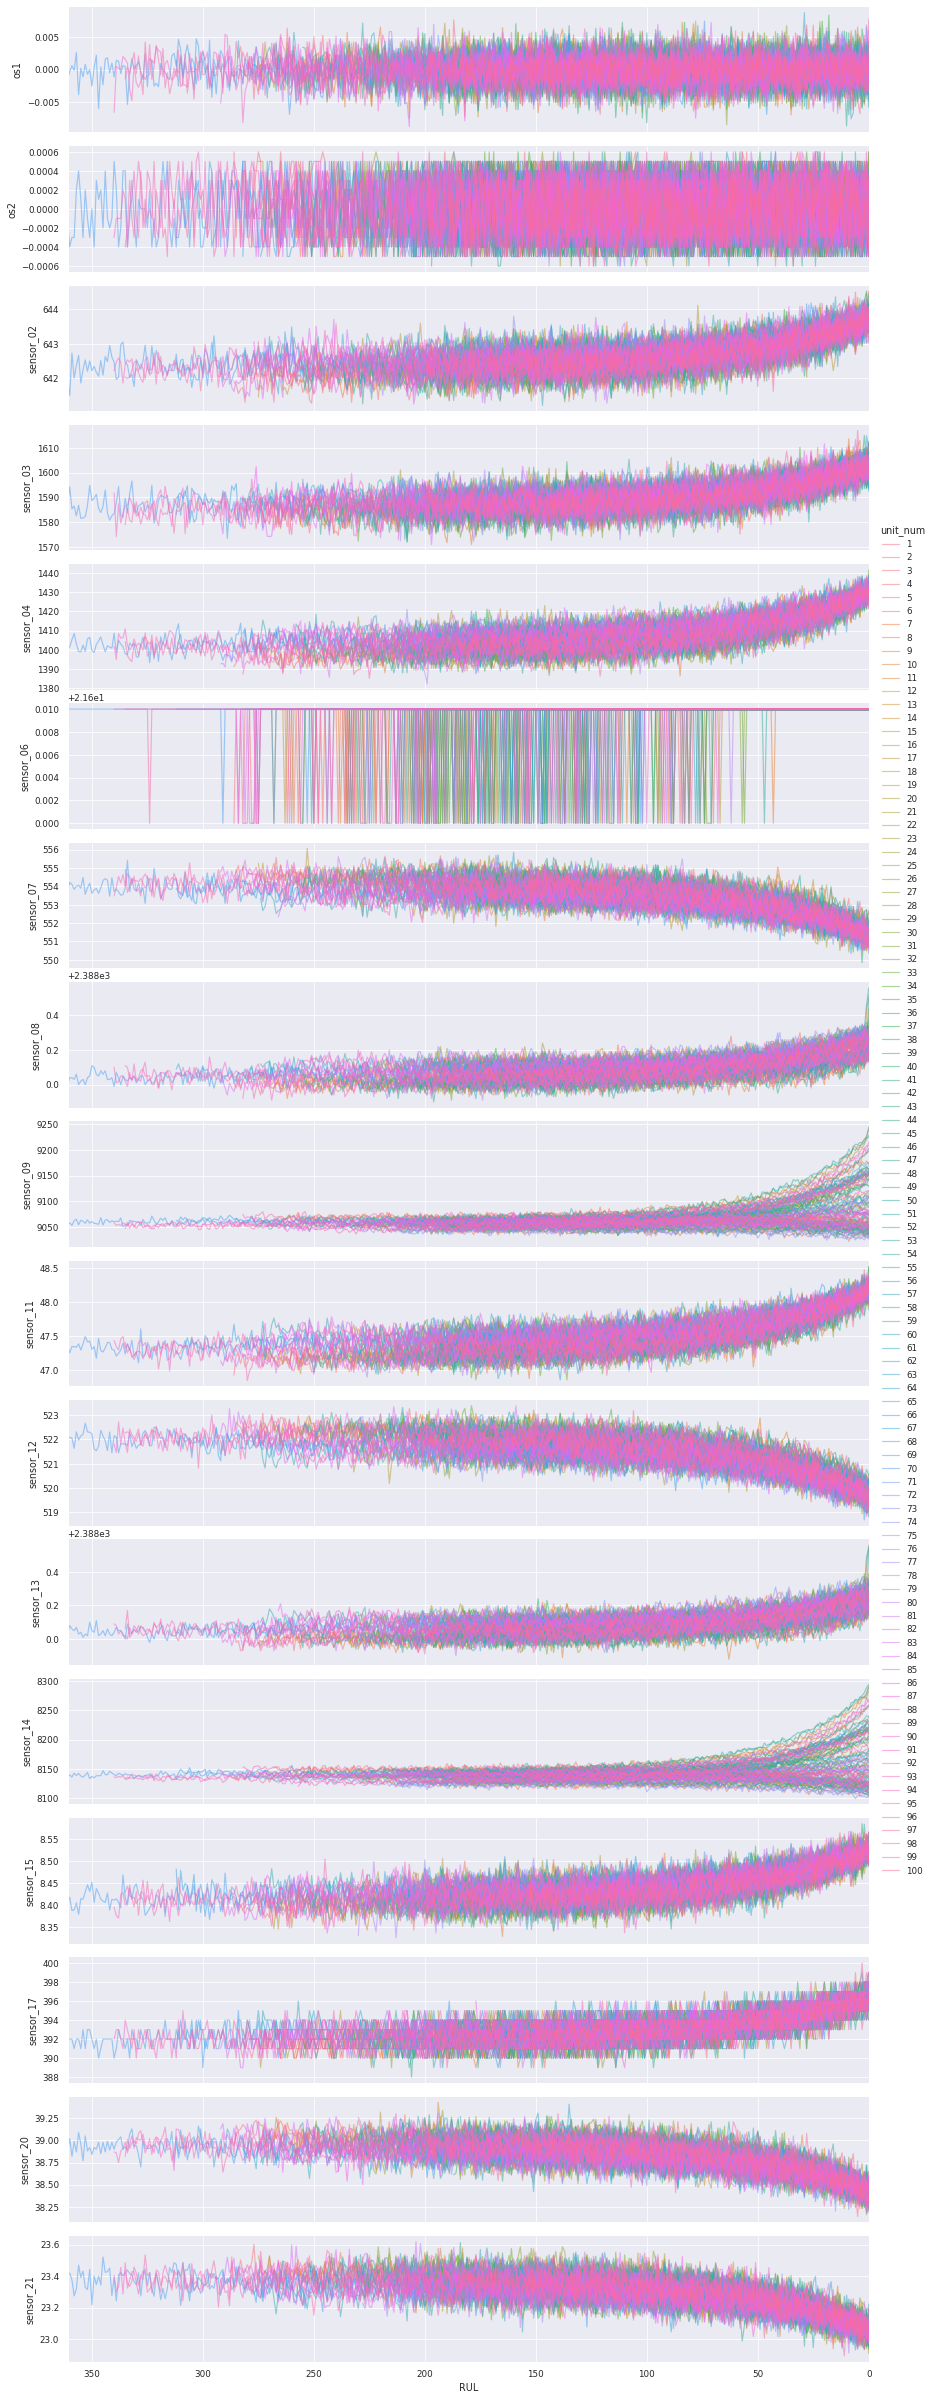

In [ ]:
# All data collected from units has been visualized according to the remaining useful lifetime. Thus, in order to determine the threshold, RUL in which the deviations in the data begin has tried to be estimated.
g = sns.PairGrid(data=df, x_vars="RUL", y_vars=df.drop(["unit_num","cycle_time","RUL"],axis=1).columns,
                 hue="unit_num", height=2, aspect=6)
g = g.map(plt.plot, alpha=0.5)
g = g.set(xlim=(df['RUL'].max(),df['RUL'].min()))
g = g.add_legend()

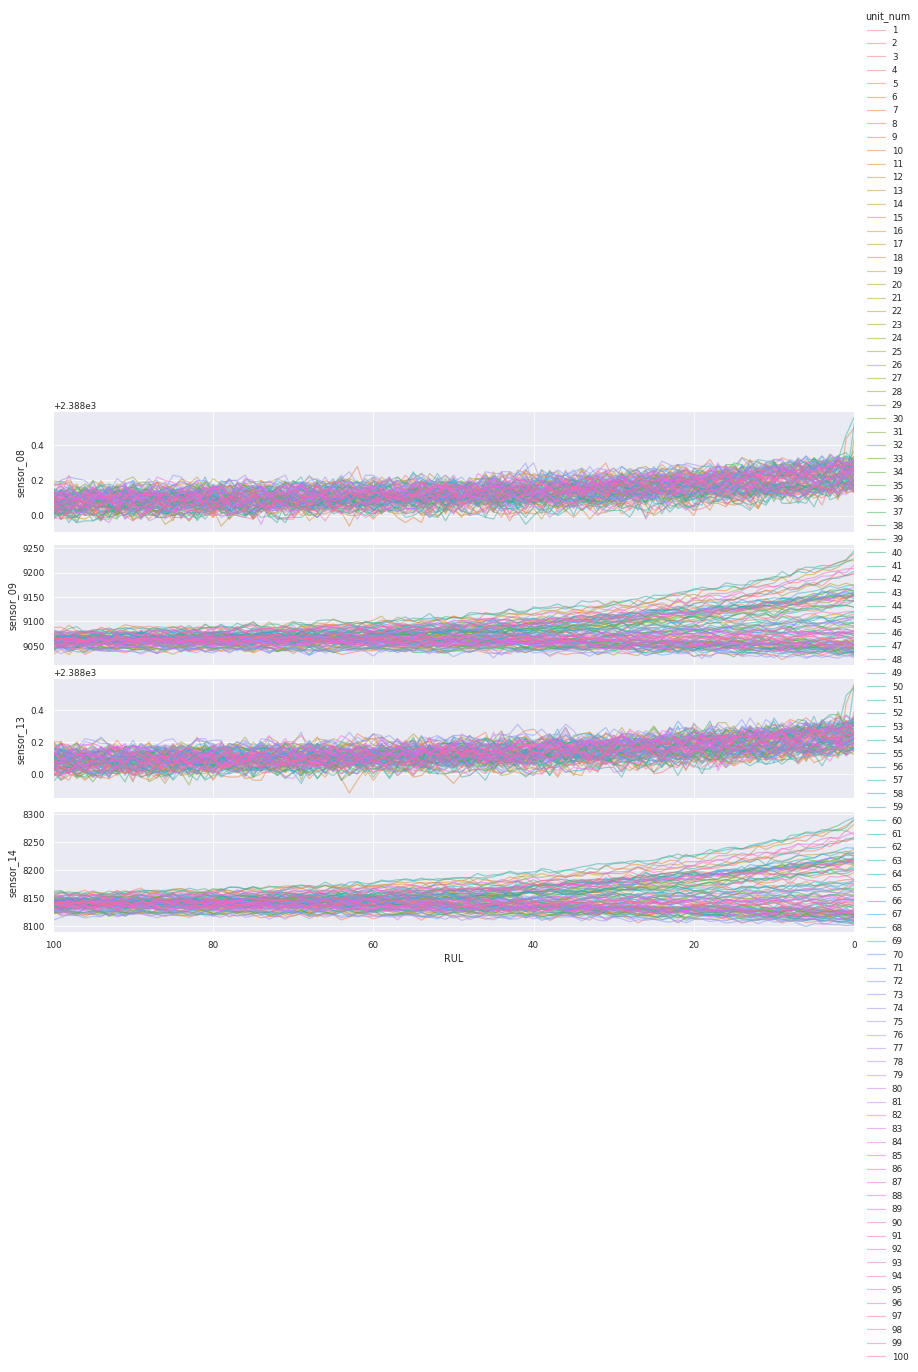

In [ ]:
df_var = df[df["RUL"]<=100][["unit_num", "sensor_08", "sensor_09", "sensor_13", "sensor_14","RUL"]]
df_var
df_var_col = ["sensor_08", "sensor_09", "sensor_13", "sensor_14"]
g = sns.PairGrid(data=df_var, x_vars="RUL", y_vars=df_var_col, hue="unit_num", height=2, aspect=6,)
g = g.map(plt.plot, alpha=0.5)
g = g.set(xlim=(df_var['RUL'].max(),df_var['RUL'].min()))
g = g.add_legend()

#### Statement
The cleaning and exploration of the turbofan data given up to this section has been made. At the same time, the target dataset column expected to be obtained as a result of the models was used. If we look at the data definition outputs, columns with no data or repeated data were found in the dataset. Data that will not contribute to the model and therefore will not be used in the model have been determined. Thus, the data set to be used in the training of the models was given its final shape.

### Regression Model Training

In [ ]:
# Performance metrics have been calculated to evaluate the trained model.

def get_reg_model_metrics(model,actual,predicted):
    
    reg_metrics = {
                        "MAE": mean_absolute_error(actual,predicted),
                        "MSE": mean_squared_error(actual,predicted),
                        "RMSE": pow(mean_squared_error(actual,predicted),0.5),
                        "R\u00b2 Score" : r2_score(actual,predicted)
                  }
    
    df_reg_metrics = pd.DataFrame.from_dict(reg_metrics, orient='index')
    df_reg_metrics.columns = [model]
    
    return df_reg_metrics

In [ ]:
# In order to train the model, X and y data has beeb prepared according to the outputs obtained from the data exploration section. 
# Afterwards, the dataset has been divided into training and test sets and the models has been trained with the training set.

def fit_model(model, data):
    metrics = pd.DataFrame()
    X = data.drop(["os1","os2","sensor_07","sensor_12","sensor_09","RUL"],axis=1)
    ss = StandardScaler()
    X = pd.DataFrame(data= ss.fit_transform(X), columns=X.columns)
    y = data["RUL"]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    i = 0
    
    for name, reg in model.items():
        print("Fitting model: " + name)
        reg.fit(X_train, y_train)
        y_pred = reg.predict(X_test)
        
        if i == 0:
            metrics = get_reg_model_metrics(name, y_test, y_pred)
            print(metrics)
            
        elif i != 0:
            new_metric = get_reg_model_metrics(name, y_test, y_pred)
            print(new_metric)
            metrics = pd.concat([metrics, new_metric],axis=1)

        i= i+1

        print("====================")
        print("\n")
        
    return metrics

In [ ]:
# Algorithms used to build the regression model.

model1 = {
    "Lasso": Lasso(alpha=0.5),
    "SVM": SVR(C=5, ),
    "Nearest Neighbor": KNeighborsRegressor(n_neighbors=9, weights="distance", p=1, ),
    "Neural Net": MLPRegressor(max_iter=500),
    "Random Forest": RandomForestRegressor(n_estimators=75),
    "Adaboost Regression": AdaBoostRegressor(base_estimator=DecisionTreeRegressor(), n_estimators=150, learning_rate=0.5),
    "XGBoost Regression": xgb.XGBRegressor(objective="reg:squarederror", max_depth=5, learning_rate=0.3, n_estimators=100),    
}

In [ ]:
fit_model(model1, df)

Fitting model: Lasso
                Lasso
MAE         30.240944
MSE       1520.815819
RMSE        38.997639
R² Score     0.667971


Fitting model: SVM
                  SVM
MAE         23.721424
MSE       1228.091970
RMSE        35.044143
R² Score     0.731880


Fitting model: Nearest Neighbor
          Nearest Neighbor
MAE              24.175830
MSE            1174.304721
RMSE             34.268130
R² Score          0.743623


Fitting model: Neural Net


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


           Neural Net
MAE         23.830604
MSE       1097.699625
RMSE        33.131550
R² Score     0.760347


Fitting model: Random Forest
          Random Forest
MAE           11.289447
MSE          288.608067
RMSE          16.988469
R² Score       0.936990


Fitting model: Adaboost Regression
          Adaboost Regression
MAE                  7.077383
MSE                131.436672
RMSE                11.464583
R² Score             0.971304


Fitting model: XGBoost Regression
          XGBoost Regression
MAE                 7.733341
MSE               107.864147
RMSE               10.385767
R² Score            0.976451




Lasso          SVM  ...  Adaboost Regression  XGBoost Regression
MAE         30.240944    23.721424  ...             7.077383            7.733341
MSE       1520.815819  1228.091970  ...           131.436672          107.864147
RMSE        38.997639    35.044143  ...            11.464583           10.385767
R² Score     0.667971     0.731880  ...             0.971304            0.976451

[4 rows x 7 columns]

#### Regression Model Evaluation

7 algorithms were trained with training sets and tested with test sets. As a result, the metrics used for model evaluation were calculated. The most important metrics in practice are the RMSE, and the R2 score. The reason RMSE is more important than MAE is that it requires penalizing major errors in the predictive maintenance framework. Because, as a result of estimating the remaining life of the machines with a great error, the machines cannot be intervened correctly. As you can see, the best case is the XGBoost algorithm, followed by the AdaBoost algorithm. The equation established in both models can explain the dataset with high accuracy. For the regression modeling, the winning algorithm chosen according to the RMSE and R2 score was chosen as XGBoost.

### Classification Model Training

In [ ]:
df_clf = df.copy()
df_clf.head()

unit_num  cycle_time     os1     os2  ...  sensor_17  sensor_20  sensor_21  RUL
0         1           1 -0.0007 -0.0004  ...        392      39.06    23.4190  191
1         1           2  0.0019 -0.0003  ...        392      39.00    23.4236  190
2         1           3 -0.0043  0.0003  ...        390      38.95    23.3442  189
3         1           4  0.0007  0.0000  ...        392      38.88    23.3739  188
4         1           5 -0.0019 -0.0002  ...        393      38.90    23.4044  187

[5 rows x 20 columns]

In [ ]:
# In order to establish the classification model, the threshold determined in the visualizations has been used. 
# The part that is above the threshold is called the class 0 which is functional RUL, 
# and the values that are below the threshold is called class 1 which is nonfunctional RUL.
df_clf["RUL_clf"] = [1 if i <= 30 else 0 for i in df_clf["RUL"] ]
df_clf["RUL_clf"]

0        0
1        0
2        0
3        0
4        0
        ..
20626    1
20627    1
20628    1
20629    1
20630    1
Name: RUL_clf, Length: 20631, dtype: int64

In [ ]:
df_clf.drop("RUL",axis=1, inplace=True)
df_clf

unit_num  cycle_time     os1  ...  sensor_20  sensor_21  RUL_clf
0             1           1 -0.0007  ...      39.06    23.4190        0
1             1           2  0.0019  ...      39.00    23.4236        0
2             1           3 -0.0043  ...      38.95    23.3442        0
3             1           4  0.0007  ...      38.88    23.3739        0
4             1           5 -0.0019  ...      38.90    23.4044        0
...         ...         ...     ...  ...        ...        ...      ...
20626       100         196 -0.0004  ...      38.49    22.9735        1
20627       100         197 -0.0016  ...      38.30    23.1594        1
20628       100         198  0.0004  ...      38.44    22.9333        1
20629       100         199 -0.0011  ...      38.29    23.0640        1
20630       100         200 -0.0032  ...      38.37    23.0522        1

[20631 rows x 20 columns]

In [ ]:
df_clf[df_clf["unit_num"] == 1].tail(30)

unit_num  cycle_time     os1  ...  sensor_20  sensor_21  RUL_clf
162         1         163  0.0003  ...      38.65    23.1419        1
163         1         164  0.0005  ...      38.62    23.1761        1
164         1         165  0.0010  ...      38.59    23.2129        1
165         1         166 -0.0022  ...      38.62    23.1450        1
166         1         167  0.0012  ...      38.77    23.3011        1
167         1         168 -0.0043  ...      38.76    23.2770        1
168         1         169 -0.0017  ...      38.58    23.1870        1
169         1         170 -0.0017  ...      38.66    23.1615        1
170         1         171  0.0004  ...      38.68    23.2444        1
171         1         172 -0.0014  ...      38.65    23.1585        1
172         1         173 -0.0032  ...      38.59    23.1789        1
173         1         174 -0.0001  ...      38.57    23.0357        1
174         1         175  0.0001  ...      38.58    23.1573        1
175         1         176 -0.0020  ...      38.72    23.2491        1
176         1         177 -0.0038  ...      38.63    23.1673        1
177         1         178 -0.0001  ...      38.65    23.1770        1
178         1         179  0.0023  ...      38.77    23.1888        1
179         1         180 -0.0024  ...      38.86    23.0070        1
180         1         181 -0.0006  ...      38.34    23.1652        1
181         1         182 -0.0010  ...      38.43    23.1787        1
182         1         183  0.0001  ...      38.56    23.1302        1
183         1         184  0.0004  ...      38.43    23.0146        1
184         1         185  0.0008  ...      38.51    23.0700        1
185         1         186  0.0027  ...      38.47    23.0564        1
186         1         187 -0.0047  ...      38.42    23.0822        1
187         1         188 -0.0067  ...      38.51    22.9588        1
188         1         189 -0.0006  ...      38.48    23.1127        1
189         1         190 -0.0027  ...      38.49    23.0675        1
190         1         191 -0.0000  ...      38.45    23.1295        1
191         1         192  0.0009  ...      38.48    22.9649        1

[30 rows x 20 columns]

In [ ]:
# Performance metrics have been calculated to evaluate the trained model.

def get_clf_model_metrics(model,actual,predicted):
    
    clf_metrics = {
                        "Accuracy Score": accuracy_score(actual, predicted),
                        "Precision Score": precision_score(actual, predicted),
                        "Recall Score": recall_score(actual, predicted),
                        "F1 Score" : f1_score(actual, predicted),
                        "Auc Score": roc_auc_score(actual, predicted)
                  }
    
    df_clf_metrics = pd.DataFrame.from_dict(clf_metrics, orient='index')
    df_clf_metrics.columns = [model]

    return df_clf_metrics

In [ ]:
# In order to train the model, X and y data has beeb prepared according to the outputs obtained from the data exploration section. 
# Afterwards, the dataset has been divided into training and test sets and the models has been trained with the training set.

def fit_clf_model(model, data):
    
    
    X = data.drop(["os1","os2","sensor_07","sensor_12","sensor_09","RUL_clf"],axis=1)
    ss = StandardScaler()
    X = pd.DataFrame(data= ss.fit_transform(X), columns=X.columns)
    y = data["RUL_clf"]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=True, stratify=y)
    
    i = 0
    
    for name, clf in model.items():
        print("Fitting model: " + name)
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        
        if i == 0:
            metrics = get_clf_model_metrics(name, y_test, y_pred)
            print(metrics)
            
        elif i != 0:
            new_metric = get_clf_model_metrics(name, y_test, y_pred)
            print(new_metric)
            metrics = pd.concat([metrics, new_metric],axis=1)

        i= i+1
        print("Plotting the Confusion Matrix...")
        plot_confusion_matrix(clf, X_test, y_test)
        plt.show()
        print("====================")
        print("\n")
        
    return metrics

In [ ]:
# Algorithms used to build the regression model.

model2 = { 
    "Nearest Neighbor": KNeighborsClassifier(n_neighbors=9, p=1),
    "Logistic Regression": LogisticRegression(),
    "RBF SVM": SVC(random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=75, random_state=42, n_jobs=-1),
    "Neural Net": MLPClassifier(alpha=1, solver='lbfgs', random_state=42, hidden_layer_sizes=(40,3)),
    "AdaBoost": AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=4, criterion='entropy'), n_estimators=150),
    "XGBoost Classifier":xgb.XGBClassifier(objective="binary:logistic", random_state=42, max_depth=4, learning_rate=0.4),
}

Fitting model: Nearest Neighbor
                 Nearest Neighbor
Accuracy Score           0.963005
Precision Score          0.900571
Recall Score             0.847312
F1 Score                 0.873130
Auc Score                0.915386
Plotting the Confusion Matrix...


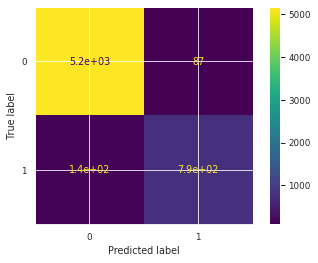



Fitting model: Logistic Regression
                 Logistic Regression
Accuracy Score              0.959935
Precision Score             0.875551
Recall Score                0.854839
F1 Score                    0.865071
Auc Score                   0.916678
Plotting the Confusion Matrix...


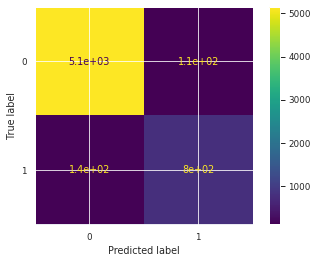



Fitting model: RBF SVM
                  RBF SVM
Accuracy Score   0.964943
Precision Score  0.904654
Recall Score     0.856989
F1 Score         0.880177
Auc Score        0.920510
Plotting the Confusion Matrix...


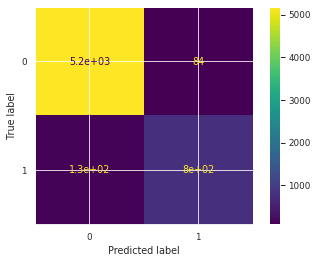



Fitting model: Random Forest
                 Random Forest
Accuracy Score        0.962197
Precision Score       0.881579
Recall Score          0.864516
F1 Score              0.872964
Auc Score             0.921992
Plotting the Confusion Matrix...


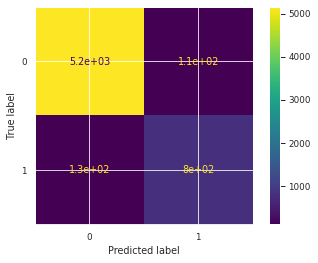



Fitting model: Neural Net


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


                 Neural Net
Accuracy Score     0.963489
Precision Score    0.879310
Recall Score       0.877419
F1 Score           0.878364
Auc Score          0.928063
Plotting the Confusion Matrix...


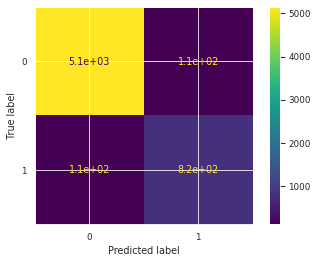



Fitting model: AdaBoost
                 AdaBoost
Accuracy Score   0.968336
Precision Score  0.903297
Recall Score     0.883871
F1 Score         0.893478
Auc Score        0.933570
Plotting the Confusion Matrix...


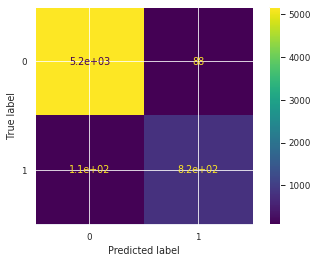



Fitting model: XGBoost Classifier
                 XGBoost Classifier
Accuracy Score             0.977221
Precision Score            0.927411
Recall Score               0.920430
F1 Score                   0.923907
Auc Score                  0.953846
Plotting the Confusion Matrix...


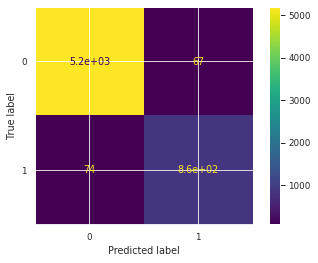

Nearest Neighbor  ...  XGBoost Classifier
Accuracy Score           0.963005  ...            0.977221
Precision Score          0.900571  ...            0.927411
Recall Score             0.847312  ...            0.920430
F1 Score                 0.873130  ...            0.923907
Auc Score                0.915386  ...            0.953846

[5 rows x 7 columns]

In [ ]:
fit_clf_model(model2, df_clf)

#### Classification Model Evaluation

7 different algorithms were trained and tested with test sets.  As a result, the metrics used for model evaluation were calculated. The metrics are listed in the table from smallest to largest. Recall score was chosen as the most important metric, since in practice it is desired to accurately predict machines close to failure. Considering the Recall score, the best algorithm is the XGBoost classifier, and the second best algorithm is AdaBoost and artificial neural networks. As can be seen, the recall score is equal for Adaboost and artificial neural networks. Therefore, by looking at the Auc score, it can be observed how well the model separates the probabilities of the positive class from the probabilities of the negative class. Therefore, AdaBoost can be chosen as the second best classifier.